## Annexe, fig. 10 : MNIST dataset, TINY vs RANDOM 

In [1]:
import sys
sys.path.append('../../TINY/')
import TINY 
import UTILS
from mes_imports import *
import load_data_Loader
import SOLVE_EB as EB

In [2]:
def generate_random_neurons(model, depth) :
    nbr = model.depth_seuil[depth]
    alpha = torch.randn((nbr, model.layer[depth]['L'].in_features), device = my_device_0)
    bias_alpha = torch.randn(nbr, device=my_device_0)
    omega = torch.randn((model.layer[depth + 1]['L'].out_features, nbr), device = my_device_0)
    lmbda = torch.randn(nbr, device = my_device_0)
    model.alpha = alpha
    model.omega = omega
    model.valeurs_propres = lmbda
    model.bias_alpha = bias_alpha
    return(alpha, bias_alpha, omega, lmbda)

In [3]:
def Loss_entropy(x1, x2, reduction = 'mean') :
    #print(x1.shape, x2.shape)
    return(torch.nn.CrossEntropyLoss(reduction = reduction)(x1, x2))

layer_name = {1 : 'L', 2 : 'L', 3 :'L'}
skeleton = {0: {}, 1 : {'size' : 1}, 2 : {'size' : 1}, 3 : {'size' : 10}}
fct = {depth : torch.nn.SELU() for depth in range(1, 3)}
fct.update({3 : torch.nn.Identity()})

In [9]:
dico_performance = {'TINY' : {}, 'Random' : {}}
tot_nbr_pass = 5
init_deplacement = 1e-8
accroissement_decay = 1e-8
lr = 1e-7
lisser = 10

In [10]:
df_tracker = pd.DataFrame(columns = ['method', 'A_te', 'A_tr'])

### TINY

In [11]:
for expe in tqdm(range(10)) :
    dico_parameters = {
                     'skeleton' : copy.deepcopy(skeleton),
                    'Loss' : Loss_entropy,
                    'fct' : fct,
                    'layer_name' :layer_name,
                    'rescale' : 'DE',
                    'init_deplacement' : init_deplacement, # min amplitude factor
                    'batch_size' : 64,# batchsize for training
                    'lr' : lr,# leraning rate for training
                    'lambda_method' : 0, # = 0 for searching the amplitude factor, if > 0 the 
                                         # amplitude factor is automatically set to this value
                    'accroissement_decay' : accroissement_decay,# the minimum decay to update the 
                                                 # architecture with the NewNeurons/BestUpdate 
                    'depth_seuil' : {1 : 500, 2 : 500}, #maximum number of neurons to add by depth
                    'lu_lin' : 5, #reduce the variance of estimators by sqrt of lu_lin > 1
                    'max_batch_estimation' : 100, # maximum size of batch at a time
                    'max_amplitude' : 20., # max amplitude factor
                    'ind_lmbda_shape' : 1000,
                    'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze it
                    'len_train_dataset' : 50000, # size of training data
                    'len_test_dataset' : 10000, # size of testing data
                    'selection_neuron' : UTILS.selection_neuron_seuil,
                    'how_to_define_batchsize' : UTILS.indices_non_constant,
                    }
    MLP_model = TINY.TINY(dico_parameters)
    MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.max_batch_estimation)
    MLP_model.tr_loader, MLP_model.te_loader =  DataLoader(MLP_model.training_data, batch_size=MLP_model.max_batch_estimation, shuffle=True),  DataLoader(MLP_model.test_data, batch_size=MLP_model.max_batch_estimation, shuffle=True)

    for nbr_pass in tqdm(range(tot_nbr_pass)) :
        for depth in [1, 2] :
            MLP_model.dico_w = None
            MLP_model.how_to_define_batchsize(MLP_model, depth + 1, method = 'NG')
            EB.compute_NG(MLP_model, depth + 1, update = False, compute_gain=False)
            MLP_model.how_to_define_batchsize(MLP_model, depth, method = 'Add')

            EB.add_neurons(MLP_model, depth, update = True)
            MLP_model.dico_w = None
            MLP_model.how_to_define_batchsize(MLP_model, depth + 1, method = 'NG')
            EB.compute_NG(MLP_model, depth + 1, update = True)
            
    A_tr_mean, A_te_mean = 0, 0
    for j in range(lisser) :
        X_tr, Y_tr = MLP_model.get_batch(data='tr')
        X_te, Y_te = MLP_model.get_batch(data='te')
        A_tr, A_te = UTILS.calculate_accuracy(MLP_model(X_tr), Y_tr), UTILS.calculate_accuracy(MLP_model(X_te), Y_te)
        A_tr_mean += A_tr / lisser
        A_te_mean += A_te / lisser
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict({'method' : ['TINY'], 'A_tr' : [A_tr_mean], 'A_te' : [A_te_mean]})], ignore_index= True)
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.8408448696136475
norm_x_over_norm_DE_depthp1 :  0.2042994648218155
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.07325387001037598, -0.11429572105407715, -0.14761972427368164]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.0612063892185688 ampli_fct : 16.0 L[0] : 2.411835193634033
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 4.76837158203125e-07]
bet

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -3.874301910400391e-06, -7.987022399902344e-06]  ... [-0.020195066928863525, -0.029061079025268555, -0.025325298309326172]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.05488521233201027 ampli_fct : 0.0001220703125 L[0] : 0.5294883251190186
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 1100


*** started  Add at  2 ***
Batch size for estimation : 1900
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 10.259598731994629
norm_x_over_norm_DE_depthp1 :  29.690628051757812
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -5.960464477539063e-08, -1.1920928955078125e-07]  ... [-0.0648198127746582, -0.07129591703414917, 0.02190500497817993]
betas :  [0

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.08888557553291321
norm_x_over_norm_DE_depthp1 :  0.2460620403289795
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.011522054672241211, -0.02316904067993164, -0.04483199119567871]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.0187841709703207 ampli_fct : 16.0 L[0] : 2.3866899013519287
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.03708314895629883, -0.0629813

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -3.6954879760742188e-06, -5.841255187988281e-06]  ... [-0.012945413589477539, -0.014346718788146973, 0.002305448055267334]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.019699733704328537 ampli_fct : 0.0001220703125 L[0] : 0.7282696962356567
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 1100


*** started  Add at  2 ***
Batch size for estimation : 1900
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.9983526468276978
norm_x_over_norm_DE_depthp1 :  10.854802131652832
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.04101592302322388, -0.04757267236709595, 0.0007592439651489258]
betas :  [0.0, 7.450580596923828e-09, 1.490116

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.20871099829673767
norm_x_over_norm_DE_depthp1 :  0.9304051995277405
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.2241067886352539, -0.3623063564300537, -0.5268635749816895]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.19991429150104523 ampli_fct : 16.0 L[0] : 2.6354472637176514
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.06604528427124023, -0.0983607769

Delta Loss :  [0.0, -4.887580871582031e-06, -9.417533874511719e-06]  ... [-0.003977060317993164, -0.006373882293701172, -0.005962491035461426]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05]
rate of decrease : 0.006287981290370226 ampli_fct : 1.52587890625e-05 L[0] : 1.0136611461639404
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 700


*** started  Add at  2 ***
Batch size for estimation : 1200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 7.047821044921875
norm_x_over_norm_DE_depthp1 :  28.569494247436523
L_plus < L_moins: 0.8603305220603943 < 0.8603305816650391
Delta Loss :  [0.0, -1.7881393432617188e-07, -3.5762786865234375e-07]  ... [-0.22935372591018677, -0.2401023507118225, -0.06741750240325928]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] 

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.02512902207672596
norm_x_over_norm_DE_depthp1 :  0.014762851409614086
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0007624626159667969, -0.0014870166778564453, -0.0025560855865478516]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.001036709756590426 ampli_fct : 16.0 L[0] : 2.4655749797821045
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.38418579101

Delta Loss :  [0.0, 0.0, -1.1920928955078125e-07]  ... [-0.053823769092559814, -0.06438308954238892, 0.014004945755004883]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.061121854931116104 ampli_fct : 0.03125 L[0] : 1.0533562898635864
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 700


*** started  Add at  2 ***
Batch size for estimation : 1100
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.9765990972518921
norm_x_over_norm_DE_depthp1 :  22.974727630615234
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.1390364170074463, -0.2029997706413269, -0.19821828603744507]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.125, 0.25, 0.5]
rate of decrease : 0.1997702419757843 ampli_fct : 0.25 L[0] : 1.0161662101745605
amplitude factor 

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.7317346930503845
norm_x_over_norm_DE_depthp1 :  1.0456347465515137
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.1920928955078125e-07, 2.384185791015625e-07, 4.76837158203125e-07]
rate of decrease : 9.853651761204674e-08 ampli_fct : 2.384185791015625e-07 L[0] : 2.4195961952209473
amplitude factor for the new neurons : 2.384185791015625e-07
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :

*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 1.5749670267105103
norm_x_over_norm_DE_depthp1 :  30.154403686523438
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.14982908964157104, -0.20670205354690552, -0.1673145890235901]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.125, 0.25, 0.5]
rate of decrease : 0.24550242722034454 ampli_fct : 0.25 L[0] : 0.8419552445411682
amplitude factor for the new neurons : 0.25
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




*** started  NG at  3 ***
Batch size for estimation : 1100
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.025488972663879395, -0.037678420543670654, -0.035997211933135986]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0625, 0.125, 0.

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.6531605124473572
norm_x_over_norm_DE_depthp1 :  1.9468070268630981
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.15422582626342773, -0.21453356742858887, -0.1987602710723877]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.0, 2.0, 4.0]
rate of decrease : 0.09030335396528244 ampli_fct : 2.0 L[0] : 2.3756988048553467
amplitude factor for the new neurons : 2.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.03827261924743652, -0.057185888290

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -3.9458274841308594e-05, -7.62939453125e-05]  ... [-0.126151442527771, -0.15465879440307617, 0.02811253070831299]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [3.0517578125e-05, 6.103515625e-05, 0.0001220703125]
rate of decrease : 0.08880488574504852 ampli_fct : 6.103515625e-05 L[0] : 1.741557240486145
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 600


*** started  Add at  2 ***
Batch size for estimation : 900
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 3.421985149383545
norm_x_over_norm_DE_depthp1 :  34.694881439208984
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -1.1920928955078125e-07, -2.384185791015625e-07]  ... [-0.28988492488861084, -0.3431081771850586, -0.037218570709228516]
betas :  [0.0, 7.450

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.14995594322681427
norm_x_over_norm_DE_depthp1 :  0.2796936631202698
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.6072492599487305


*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.05132126808166504, -0.1115274429321289, -0.09168839454650879]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.25, 0.5, 1.0]
rate of decrease : 0.0

Delta Loss :  [0.0, -9.5367431640625e-07, -1.9073486328125e-06]  ... [-0.04402977228164673, -0.06027907133102417, -0.019006311893463135]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.060178954154253006 ampli_fct : 0.0009765625 L[0] : 1.0016636848449707
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 400


*** started  Add at  2 ***
Batch size for estimation : 1000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 4.217104434967041
norm_x_over_norm_DE_depthp1 :  28.185216903686523
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, -1.1920928955078125e-07]  ... [-0.07117581367492676, -0.09726691246032715, -0.06599903106689453]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.1472283899784088

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.08274222910404205
norm_x_over_norm_DE_depthp1 :  0.0941598117351532
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-4.76837158203125e-07, -4.76837158203125e-07, -2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 1.9385159077955905e-07 ampli_fct : 6.103515625e-05 L[0] : 2.4598052501678467
amplitude factor for the new neurons : 6.103515625e-05
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.960464477539062e-07, -1.3709068298339844e-06]  ... [-0.005258381366729736, -0.008479058742523193, -0.007856667041778564]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.01113040279597044 ampli_fct : 0.0001220703125 L[0] : 0.7617926001548767
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 1100


*** started  Add at  2 ***
Batch size for estimation : 1900
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 2.6742806434631348
norm_x_over_norm_DE_depthp1 :  44.25057601928711
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.04936772584915161, -0.07320922613143921, -0.06929010152816772]
betas :  [0.0, 7.450580596923828e-09, 1.49011611

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.006362325977534056
norm_x_over_norm_DE_depthp1 :  0.0088131008669734
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-8.845329284667969e-05, -0.00016927719116210938, -0.00032639503479003906]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.00013271825446281582 ampli_fct : 16.0 L[0] : 2.4593076705932617
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.02624845504760742

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.245208740234375e-06, -9.5367431640625e-06]  ... [-0.027958393096923828, -0.03674435615539551, -0.004873752593994141]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.017643285915255547 ampli_fct : 0.0001220703125 L[0] : 2.082625389099121
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 1100


*** started  Add at  2 ***
Batch size for estimation : 900
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.2896779179573059
norm_x_over_norm_DE_depthp1 :  2.746100425720215
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.450580596923828e-

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.36396780610084534
norm_x_over_norm_DE_depthp1 :  0.8928834199905396
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.1714344024658203, -0.25690722465515137, -0.31795382499694824]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.1209576427936554 ampli_fct : 16.0 L[0] : 2.6286377906799316
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 200
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.027106046676635742, -0.06245851

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.4901161193847656e-06, -2.9802322387695312e-06]  ... [-0.029030561447143555, -0.031190812587738037, 0.038123130798339844]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.045595940202474594 ampli_fct : 0.00048828125 L[0] : 0.6840699315071106
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 1100


*** started  Add at  2 ***
Batch size for estimation : 1900
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 8.231342315673828
norm_x_over_norm_DE_depthp1 :  44.79255294799805
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -1.7881393432617188e-07, -1.7881393432617188e-07]  ... [-0.03437000513076782, -0.04803258180618286, -0.034196674823760986]
betas :  [0.0,

In [15]:
df_tracker

,method,A_te,A_tr
0,TINY,0.874,0.884
1,TINY,0.891,0.901
2,TINY,0.842,0.848
3,TINY,0.849,0.840
4,TINY,0.884,0.872
5,TINY,0.858,0.887
6,TINY,0.873,0.882
7,TINY,0.882,0.867
8,TINY,0.278,0.248
9,TINY,0.881,0.888


### Random

In [13]:
for expe in tqdm(range(10)) :
    dico_parameters = {
                         'skeleton' : copy.deepcopy(skeleton),
                        'Loss' : Loss_entropy,
                        'fct' : fct,
                        'layer_name' :layer_name,
                        'rescale' : 'DE',
                        'init_deplacement' : init_deplacement, # min amplitude factor
                        'batch_size' : 64,# batchsize for training
                        'lr' : lr,# leraning rate for training
                        'lambda_method' : 0, # = 0 for searching the amplitude factor, if > 0 the 
                                             # amplitude factor is automatically set to this value
                        'accroissement_decay' : accroissement_decay,# the minimum decay to update the 
                                                     # architecture with the NewNeurons/BestUpdate 
                        'depth_seuil' : {1 : 500, 2 : 500}, #maximum number of neurons to add by depth
                        'lu_lin' : 5, #reduce the variance of estimators by sqrt of lu_lin > 1
                        'max_batch_estimation' : 100, # maximum size of batch at a time
                        'max_amplitude' : 20., # max amplitude factor
                        'ind_lmbda_shape' : 1000,
                        'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze it
                        'len_train_dataset' : 50000, # size of training data
                        'len_test_dataset' : 10000, # size of testing data
                        'selection_neuron' : UTILS.selection_neuron_seuil,
                        'how_to_define_batchsize' : UTILS.indices_non_constant,
                        }
    MLP_model = TINY.TINY(dico_parameters)
    MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.max_batch_estimation)
    MLP_model.tr_loader, MLP_model.te_loader =  DataLoader(MLP_model.training_data, batch_size=MLP_model.max_batch_estimation, shuffle=True),  DataLoader(MLP_model.test_data, batch_size=MLP_model.max_batch_estimation, shuffle=True)
    for nbr_pass in tqdm(range(tot_nbr_pass)) :
        for depth in [1, 2] :
            MLP_model.dico_w = None
            MLP_model.how_to_define_batchsize(MLP_model, depth, method = 'Add')
            ## generate random neurons
            alpha, bias_alpha, omega, vps = generate_random_neurons(MLP_model, depth)
            EB.add_neurons(MLP_model, depth, alpha =alpha, bias_alpha =bias_alpha, omega = omega, valeurs_propres = vps, update = True)
            ## generate random BesUpdate
            MLP_model.dico_w = {}
            MLP_model.dico_w['weight'] = torch.randn_like(MLP_model.layer[depth + 1]['L'].weight)
            MLP_model.dico_w['bias'] = torch.randn_like(MLP_model.layer[depth + 1]['L'].bias)
            EB.compute_NG(MLP_model, depth + 1, update = True)
            
    A_tr_mean, A_te_mean = 0, 0
    for j in range(lisser) :
        X_tr, Y_tr = MLP_model.get_batch(data='tr')
        X_te, Y_te = MLP_model.get_batch(data='te')
        A_tr, A_te = UTILS.calculate_accuracy(MLP_model(X_tr), Y_tr), UTILS.calculate_accuracy(MLP_model(X_te), Y_te)
        A_tr_mean += A_tr / lisser
        A_te_mean += A_te / lisser
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict({'method' : ['Random'], 'A_tr' : [A_tr_mean], 'A_te' : [A_te_mean]})], ignore_index= True)
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0007140475208871067
norm_x_over_norm_DE_depthp1 :  0.0008293443243019283
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.530055046081543


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.530055046081543


*** started  Add at  2 ***
Batch size for estimation : 200
*** 

Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4990453720092773


*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.007142066955566406, -0.007793426513671875, 0.01101064682006836]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.25, 0.5, 1.0]
rate of decrease : 0.0031185613479465246 ampli_fct : 0.5 L[0] : 2.4990453720092773
*** updated layer : 2 ***


*** started  Add at  2 ***
Batch size for estimation : 25100
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.005637258756905794
norm_x_over_norm_DE_depthp1 :  0.015620707534253597
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0007199689862318337
norm_x_over_norm_DE_depthp1 :  0.0007488440023735166
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 4.76837158203125e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.451923370361328


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.451923370361328


*** started  Add at  2 ***
Batch size for estimation : 200
***

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0018491744995117188, -0.003316640853881836, -0.005387306213378906]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.0, 8.0, 16.0]
rate of decrease : 0.0021900220308452845 ampli_fct : 16.0 L[0] : 2.459932327270508
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -2.384185791015625e-07]  ... [0.0, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.450580596923828e-09, 1.4901161193847656e-08, 2.9802322387695312e-08]
rate of decrease : 9.713351545315163e-08 ampli_fct : 1.4901161193847656e-08 L[0] : 2.454545021057129
*** updated layer : 2 ***


*** started  Add at  2 ***
Batch size for estimation : 50000
*** ADD : THRESHOLD SELECTION ***

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0007935524336062372
norm_x_over_norm_DE_depthp1 :  0.0006744712591171265
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.548567056655884


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-2.384185791015625e-07, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.1920928955078125e-07, 2.384185791015625e-07, 4.76837158203125e-07]
rate of decrease : 9.355004948474743e-08 ampli_fct : 5.960464477539063e-08 L[0] : 2.548567056655884
***

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0012278556823730469, -0.001773834228515625, -0.0008418560028076172]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.0006986309308558702 ampli_fct : 0.0625 L[0] : 2.5390148162841797
*** updated layer : 3 ***


*** started  Add at  1 ***
Batch size for estimation : 50000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0594278946518898
norm_x_over_norm_DE_depthp1 :  0.0004302022571209818
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, -2.384185791015625e-07, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05]
rate of decrease : 9.198926420594944e-08 ampli_fct : 3.0517578125e-05 L[0] : 2.591808795928955
amplitude factor for the new neurons : 3.0517578125e-05
(alpha, omega) <-- (sqrt(ampl) x alpha, sq

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0015570934629067779
norm_x_over_norm_DE_depthp1 :  0.0012270243605598807
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.42126727104187


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.1920928955078125e-07, 2.384185791015625e-07, 4.76837158203125e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.42126727104187


*** started  Add at  2 ***
Batch size for estimation : 200


Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.3878841400146484


*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06]
rate of decrease : 9.984511706306876e-08 ampli_fct : 3.814697265625e-06 L[0] : 2.3878841400146484
*** updated layer : 2 ***


*** started  Add at  2 ***
Batch size for estimation : 25100
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.04327469319105148
norm_x_over_norm_DE_depthp1 :  0.022683726623654366
(alpha, omega) <-- (-alpha, -omega)
Delt

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0006758683593943715
norm_x_over_norm_DE_depthp1 :  0.002342150080949068
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.3629086017608643


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0031163692474365234, -0.004569292068481445, 0.005440950393676758]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.125, 0.25, 0.5]
rate of decrease : 0.0019337574485689402 ampli_fct : 0.25 L[0] : 2.3629086017608643
*** updated layer : 2 ***


*** start

Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 4.76837158203125e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4091954231262207


*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4091954231262207


*** started  Add at  2 ***
Batch size for estimation : 25100
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.00578736700117588
norm_x_over_norm_DE_depthp1 :  0.015995891764760017
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.00080305669689551
norm_x_over_norm_DE_depthp1 :  0.0021095273550599813
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.758396863937378


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [2.9802322387695312e-08, 5.960464477539063e-08, 1.1920928955078125e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.758396863937378


*** started  Add at  2 ***
Batch size fo

Delta Loss :  [0.0, 0.0, 0.0]  ... [-2.384185791015625e-07, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 8.855476352209735e-08 ampli_fct : 3.814697265625e-06 L[0] : 2.692329168319702
amplitude factor for the new neurons : 3.814697265625e-06
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [4.76837158203125e-07, 9.5367431640625e-07, 1.9073486328125e-06]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.692328929901123


*** started  Add at  2 ***
Batch size for estimation : 50000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| 

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0007166695431806147
norm_x_over_norm_DE_depthp1 :  0.003139281179755926
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 7.152557373046875e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.7230021953582764


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.1920928955078125e-07, 2.384185791015625e-07, 4.76837158203125e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.7230021953582764


*** started  Add at  2 ***
Batch size for estimation : 2

Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [2.384185791015625e-07, 4.76837158203125e-07, 9.5367431640625e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4943668842315674


*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 2.384185791015625e-07]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0, 7.450580596923828e-09, 1.4901161193847656e-08]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4943668842315674


*** started  Add at  2 ***
Batch size for estimation : 50000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.05083665996789932
norm_x_over_norm_DE_depthp1 :  0.01326411310583353
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0007541576633229852
norm_x_over_norm_DE_depthp1 :  0.0014523658901453018
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.5141685009002686


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [2.384185791015625e-07, 4.76837158203125e-07, 9.5367431640625e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.5141685009002686


*** started  Add at  2 ***
Batch size for estimat

Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [3.0517578125e-05, 6.103515625e-05, 0.0001220703125]
rate of decrease : 9.373231790732461e-08 ampli_fct : 6.103515625e-05 L[0] : 2.5436112880706787
amplitude factor for the new neurons : 6.103515625e-05
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.4901161193847656e-08, 2.9802322387695312e-08, 5.960464477539063e-08]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.5436110496520996


*** started  Add at  2 ***
Batch size for estimation : 50000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
no

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0010290094651281834
norm_x_over_norm_DE_depthp1 :  0.000531190016772598
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4219601154327393


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [2.384185791015625e-07, 4.76837158203125e-07, 9.5367431640625e-07]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4219601154327393


*** started  Add at  2 ***
Batch size for estimation : 2

Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.441615581512451


*** started  Add at  2 ***
Batch size for estimation : 200
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.029003197327256203
norm_x_over_norm_DE_depthp1 :  0.020973986014723778
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, -4.76837158203125e-07, -2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 1.968244021099963e-07 ampli_fct : 0.0001220703125 L[0] : 2.4226527214050293
amplitude factor for the new neurons : 0.0001220703125
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




*** star

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  Add at  1 ***
Batch size for estimation : 4000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0014026220887899399
norm_x_over_norm_DE_depthp1 :  0.0011050185421481729
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4919180870056152


*** started  NG at  2 ***
Batch size for estimation : 4000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [0.0, 0.0, 2.384185791015625e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.450580596923828e-09, 1.4901161193847656e-08, 2.9802322387695312e-08]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 2.4919180870056152


*** started  Add at  2 ***
Batch

Delta Loss :  [0.0, 0.0, 0.0]  ... [-2.384185791015625e-07, -2.384185791015625e-07, 0.0]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05]
rate of decrease : 9.699715519673191e-08 ampli_fct : 9.5367431640625e-07 L[0] : 2.457995653152466
amplitude factor for the new neurons : 9.5367431640625e-07
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  2 ***
Batch size for estimation : 50000
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0068247318267822266, -0.009184122085571289, -0.0069522857666015625]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.5, 1.0, 2.0]
rate of decrease : 0.003736427752301097 ampli_fct : 1.0 L[0] : 2.4579954147338867
*** updated layer : 2 ***


*** started  Add at  2 ***
Batch size for estimation : 50000
*** ADD : THRESHOLD SELECTION ***
***

In [ ]:
#df_tracker.to_csv('csv/df_tracker_TINY_vs_random.csv')

## Plot

In [28]:
ft = 13
plt.rcParams.update({'font.size': ft})


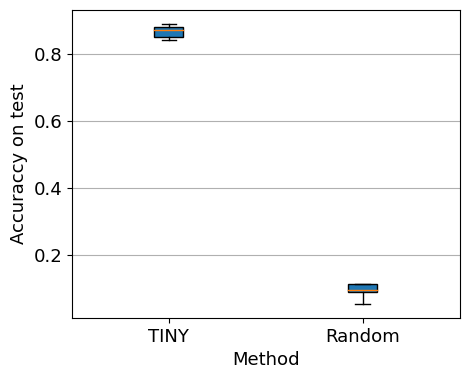

In [31]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
bplot1 = ax.boxplot([df_tracker[df_tracker['method'] == 'TINY']['A_te'].values, 
                      df_tracker[df_tracker['method'] == 'Random']['A_te'].values],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['TINY', 'Random'],
                     showfliers = False, )  # will be used to label x-ticks
#ax.set_title('Rectangular box plot')
ax.yaxis.grid(True)
ax.set_xlabel('Method', fontsize = ft)
ax.set_ylabel('Accuraccy on test', fontsize = ft)
plt.savefig('figures/TINY_vs_Random_MNIST.png', bbox_inches = 'tight')
plt.show()
